In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import imagenet_utils
import os, glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import Callback,EarlyStopping
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from sklearn.metrics import  classification_report

In [3]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Model


def residual_block(inputs, filters, strides=1):
    identity = inputs

    x = layers.Conv2D(filters, kernel_size=3, strides=strides, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Residual connection
    if strides != 1 or identity.shape[-1] != filters:
        identity = layers.Conv2D(filters, kernel_size=1, strides=strides, padding='same')(identity)
        identity = layers.BatchNormalization()(identity)

    x = layers.Add()([x, identity])
    x = layers.ReLU()(x)
    return x

input_shape = (256,256,3)
num_classes = 38
def build_rest(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    # Entry flow
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    # Middle flow (stack residual blocks)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)

    # Exit flow
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

# Define the input shape and number of classes
input_shape = (256, 256, 3)  # Adjust based on your image size and channels
num_classes = 38  # Define the number of disease classes in your dataset

# Build the ResT model
rest_model = build_rest(input_shape, num_classes)

# Compile the model
rest_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Directory paths for train, validation, and test sets
train_dir="/content/drive/MyDrive/data/Plant Diseases Dataset/Plant Diseases Dataset/train"
valid_dir="/content/drive/MyDrive/data/Plant Diseases Dataset/Plant Diseases Dataset/valid"
test_dir="/content/drive/MyDrive/data/test"



# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Normalization for validation and test data
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Generate data iterators using ImageDataGenerator
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse'  # Use 'sparse' for sparse categorical labels
)

val_gen = val_test_datagen.flow_from_directory(
    valid_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse'
)


# Set up callbacks (early stopping and model checkpoint)
es = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=3, verbose=1)
mc = ModelCheckpoint(filepath="best_model.h5", monitor='val_accuracy', min_delta=0.01, patience=3, verbose=1, save_best_only=True)

callbacks = [es, mc]

# Train the model
history = rest_model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks=callbacks,
    validation_steps=16,
    steps_per_epoch=16
)

Found 70312 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
Epoch 1/10
16/16 [==============================] - ETA: 0s - loss: 3.6829 - accuracy: 0.0938
Epoch 1: val_accuracy improved from -inf to 0.02734, saving model to best_model.h5
16/16 [==============================] - 250s 16s/step - loss: 3.6829 - accuracy: 0.0938 - val_loss: 3.7063 - val_accuracy: 0.0273


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/10
16/16 [==============================] - ETA: 0s - loss: 3.0720 - accuracy: 0.2168
Epoch 2: val_accuracy improved from 0.02734 to 0.05469, saving model to best_model.h5
16/16 [==============================] - 241s 15s/step - loss: 3.0720 - accuracy: 0.2168 - val_loss: 3.6478 - val_accuracy: 0.0547
Epoch 3/10
16/16 [==============================] - ETA: 0s - loss: 2.9012 - accuracy: 0.1973
Epoch 3: val_accuracy did not improve from 0.05469
16/16 [==============================] - 231s 15s/step - loss: 2.9012 - accuracy: 0.1973 - val_loss: 3.9112 - val_accuracy: 0.0273
Epoch 4/10
16/16 [==============================] - ETA: 0s - loss: 2.7209 - accuracy: 0.2363
Epoch 4: val_accuracy did not improve from 0.05469
16/16 [==============================] - 237s 15s/step - loss: 2.7209 - accuracy: 0.2363 - val_loss: 4.1345 - val_accuracy: 0.0195
Epoch 5/10
16/16 [==============================] - ETA: 0s - loss: 2.5256 - accuracy: 0.3262
Epoch 5: val_accuracy did not improve from 

In [4]:
acc = rest_model.evaluate_generator(val_gen)[1]
print ( f" The accuracy of your model is {acc*100} %")

<ipython-input-4-06a21aa9b1ca>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  acc = rest_model.evaluate_generator(val_gen)[1]


 The accuracy of your model is 2.4186205118894577 %


In [5]:
from sklearn.metrics import f1_score
predictions = rest_model.predict(val_gen)
# Extract true labels from the validation generator
true_labels = val_gen.classes
# Convert predictions to class labels by taking the argmax along the columns
predicted_labels = predictions.argmax(axis=1)
# Calculate the F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')  # Use 'weighted' for multi-class classification
print(f'F1 Score: {f1:.4f}')


550/550 [==============================] - 735s 1s/step
F1 Score: 0.0024


In [7]:
h=history.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

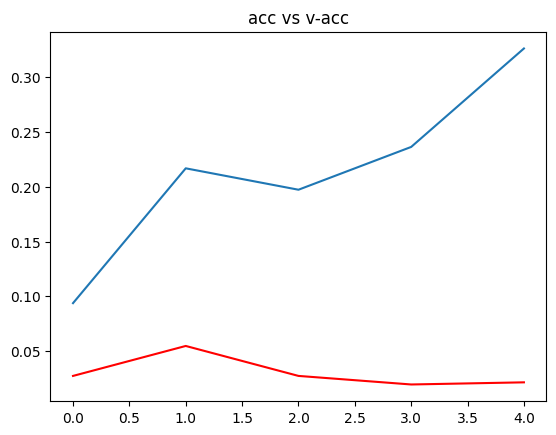

In [8]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c= "red")
plt.title("acc vs v-acc")
plt.show()

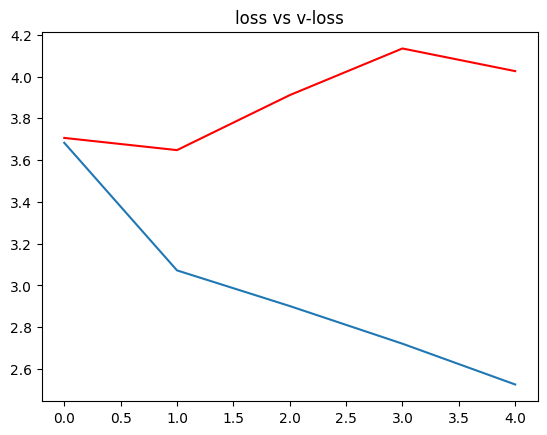

In [9]:
plt.plot(h['loss'])
plt.plot(h['val_loss'], c= "red")
plt.title("loss vs v-loss")
plt.show()

In [10]:
#load best model

from keras.models import load_model
model = load_model("/content/best_model.h5")
#from keras.models import load_model
model = load_model("/content/best_model.h5")
ref = dict(zip(list(train_gen.class_indices.values()),list(train_gen.class_indices.keys())))
ref
def prediction(path):
  img = load_img(path, target_size= (256,256))
  i = img_to_array(img)
  im = preprocess_input(i)
  img = np.expand_dims(im, axis =0)
  pred =np.argmax(model.predict(img))
  print(f" the image belongs to {ref[pred]}")

In [11]:
from tensorflow.keras.preprocessing.image import load_img,  img_to_array

path = "/content/drive/MyDrive/data/test/test/PotatoEarlyBlight1.JPG"
prediction(path)

1/1 [==============================] - 0s 273ms/step
 the image belongs to Tomato___Tomato_mosaic_virus


In [12]:
path = "/content/drive/MyDrive/data/test/test/TomatoYellowCurlVirus3.JPG"
prediction(path)

1/1 [==============================] - 0s 56ms/step
 the image belongs to Corn_(maize)___Common_rust_


In [13]:
path = "/content/drive/MyDrive/data/test/test/PotatoHealthy1.JPG"
prediction(path)

1/1 [==============================] - 0s 49ms/step
 the image belongs to Corn_(maize)___Common_rust_
